In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
#!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
#!apt-get update -qq 2>&1 > /dev/null
#!apt-get -y install -qq google-drive-ocamlfuse fuse
!wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!apt-get install -f
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import cv2
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
from tqdm import tqdm

In [0]:
def load_path(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    return files

In [0]:
def extract(img):
    imag = cv2.imread(img)
    imag = cv2.cvtColor(imag,cv2.COLOR_BGR2GRAY)
    imag = imag/255
    imag = np.expand_dims(imag,axis=2)
    return imag

In [0]:
def tensor_4d(img_fol):
    list_of_tensors = [extract(im) for im in tqdm(img_fol)]
    return np.stack(list_of_tensors,axis=0)

In [0]:
def model_inputs(real_dim,z_dim):
    real_inp = tf.placeholder(dtype='float32',shape=[None,real_dim[0],real_dim[1],real_dim[2]])
    z_inp = tf.placeholder(dtype='float32',shape=[None,z_dim])
    return real_inp,z_inp

In [0]:
def generator(z,out_dim,n_units,alp,reuse=False):
    with tf.variable_scope('generator',reuse=reuse):
        la1 = tf.layers.dense(z,16*16*2*n_units,activation=None)
        la1 = tf.reshape(la1,(-1,16,16,2*n_units))
        la1 = tf.layers.batch_normalization(la1,training=True)
        la1 = tf.nn.leaky_relu(la1,alpha=alp)

        la2 = tf.layers.conv2d_transpose(la1,n_units,strides=(2,2),kernel_size=3,activation=None,padding='same')
        la2 = tf.layers.batch_normalization(la2,training=True)
        la2 = tf.nn.leaky_relu(la2,alpha=alp)

        la3 = tf.layers.conv2d_transpose(la2,out_dim,kernel_size=3,strides=(2,2),activation=tf.nn.relu,padding='same')
        return la3

In [0]:
def discriminator(x,n_units,alp,reuse=False):
    with tf.variable_scope('discriminator',reuse=reuse):
        lay1 = tf.layers.conv2d(x,n_units,kernel_size=3,strides=(2,2),padding='same')
        lay1 = tf.layers.flatten(lay1)
        lay1 = tf.layers.batch_normalization(lay1,training=True)
        lay1 = tf.nn.leaky_relu(lay1,alpha=alp)

        lay2 = tf.layers.dense(lay1,1,activation=None)
        out = tf.nn.sigmoid(lay2)
        return lay2,out

In [0]:
input_size = (64,64,1)
z_size = 100
g_units = 16
d_units = 4
alph = 0.01
smoothing = 0.1

In [22]:
fil = load_path('drive/datasets/images')
tens = tensor_4d(fil)


100%|██████████| 1059/1059 [00:03<00:00, 271.78it/s]


In [14]:
tf.reset_default_graph()
input_real,z_real = model_inputs(input_size,z_size)
g_model = generator(z_real,input_size[2],n_units=g_units,alp=alph)
d_real_log,d_real_out = discriminator(input_real,n_units=d_units,alp=alph)
d_fake_log,d_fake_out = discriminator(g_model,n_units=d_units,alp=alph,reuse=True)

ValueError: ignored

In [0]:
lab = tf.ones_like(d_real_log)*(1-smoothing)
d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_log,labels=lab)
d_loss_real = tf.reduce_mean(d_loss_real)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_log,labels=tf.zeros_like(d_fake_log))
d_loss_fake = tf.reduce_mean(d_loss_fake)
d_loss = d_loss_real + d_loss_fake
g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_log,labels=tf.ones_like(d_fake_log))
g_loss = tf.reduce_mean(g_loss)

In [0]:
lr = 0.001
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
d_train_opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(d_loss,var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(g_loss,var_list=g_vars)

In [0]:
batch = 100
epochs = 5000
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)
init = tf.global_variables_initializer()

In [45]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        for start,end in zip(range(0,len(tens),batch),range(batch,len(tens),batch)):
            im = tens[start:end]
            im = im*2 - 1
            bat_z = np.random.uniform(-1,1,size=(batch,z_size))
            _ = sess.run(d_train_opt,feed_dict={input_real:im,z_real:bat_z})
            _ = sess.run(g_train_opt,feed_dict={z_real:bat_z})

        train_loss_d = sess.run(d_loss,feed_dict={input_real:im,z_real:bat_z})
        train_loss_g = sess.run(g_loss,feed_dict={z_real:bat_z})
        print('Epoch:',epoch,'Dis loss:',train_loss_d,'Gen loss:',train_loss_g)
    sam_z = np.random.uniform(-1,1,size=(2,z_size))
    imj = sess.run(generator(z_real,input_size[2],n_units=g_units,alp=alph,reuse=True),feed_dict={z_real:sam_z})

Epoch: 0 Dis loss: 1.7662635 Gen loss: 0.7183535
Epoch: 1 Dis loss: 1.8521839 Gen loss: 0.5576106
Epoch: 2 Dis loss: 2.0240014 Gen loss: 0.4200888
Epoch: 3 Dis loss: 2.0187159 Gen loss: 0.38960263
Epoch: 4 Dis loss: 1.7613904 Gen loss: 0.44242272
Epoch: 5 Dis loss: 1.197391 Gen loss: 0.78538597
Epoch: 6 Dis loss: 1.3335859 Gen loss: 0.86838746
Epoch: 7 Dis loss: 1.3338737 Gen loss: 0.9047138
Epoch: 8 Dis loss: 1.3213629 Gen loss: 0.92152333
Epoch: 9 Dis loss: 1.3420285 Gen loss: 0.8984326
Epoch: 10 Dis loss: 1.2901435 Gen loss: 0.9392837
Epoch: 11 Dis loss: 1.2231474 Gen loss: 0.9436152
Epoch: 12 Dis loss: 1.1759279 Gen loss: 0.9991245
Epoch: 13 Dis loss: 1.4483294 Gen loss: 0.8249626
Epoch: 14 Dis loss: 1.4099331 Gen loss: 0.8052639
Epoch: 15 Dis loss: 1.3966372 Gen loss: 0.8177277
Epoch: 16 Dis loss: 1.5346715 Gen loss: 0.68706113
Epoch: 17 Dis loss: 1.4767505 Gen loss: 0.78692275
Epoch: 18 Dis loss: 1.4875214 Gen loss: 0.75090784
Epoch: 19 Dis loss: 1.5555606 Gen loss: 0.7352839
Epo

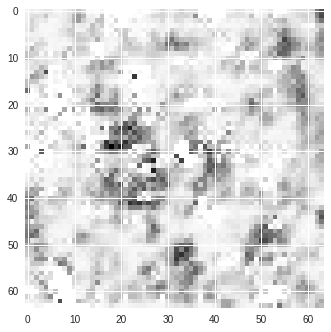

In [49]:
imgh = cv2.cvtColor(imj[1],cv2.COLOR_GRAY2BGR)
imgh = cv2.cvtColor(imgh,cv2.COLOR_BGR2GRAY)
imgh = imgh.astype('float')
plt.imshow(imgh,interpolation='none')
plt.show()

In [18]:
imj[0]

array([[[ 1.6459413, 24.45313  ,  3.0739815],
        [ 5.7242723, 13.291935 , 14.740459 ],
        [16.134102 , 36.385548 , 25.781929 ],
        ...,
        [10.4190445, 19.867018 , 18.31725  ],
        [20.3541   , 42.783527 , 24.474789 ],
        [10.3416   , 21.194485 , 31.96605  ]],

       [[ 8.399321 , 20.963459 ,  6.054446 ],
        [ 1.0030521, 40.84203  , 11.263527 ],
        [24.88691  , 34.08773  , 18.51398  ],
        ...,
        [ 5.161187 , 65.2774   , 38.407036 ],
        [31.123302 , 51.59925  , 29.311632 ],
        [43.687546 , 64.04437  , 20.781557 ]],

       [[14.848322 , 33.03938  , 23.065834 ],
        [26.086731 , 16.32033  , 34.907207 ],
        [29.427937 , 31.254559 , 41.0813   ],
        ...,
        [38.807808 , 28.70379  , 50.057224 ],
        [40.163216 , 37.801735 , 43.871017 ],
        [24.804407 , 11.789992 , 59.981743 ]],

       ...,

       [[ 0.       ,  8.002611 ,  5.6338925],
        [ 0.       , 42.994385 ,  0.       ],
        [ 5.355857 ,  